# **Install**

In [ ]:
!pip install numpy==1.26.0
!pip install pandas==2.2.1
!pip install seaborn==0.13.2
!pip install matplotlib==3.8.3
!pip install scikit-learn==1.4.1.post1

# **Import**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **Used Functions**

In [3]:
#Write here your function with comments

# **Data**

### **Data Read**

In [4]:
data=pd.read_csv("ApartmentRentPrediction.csv")

### **Data Header**

In [5]:
data.head(5)

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5508832632,housing/rent/apartment,"Two BR - $1,194/mo - Apartment - come and see ...","Come experience. in Cary, NC offering recently...","Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2.5,2.0,USD,No,Thumbnail,...,"$1,194",Monthly,800,NaN,Cary,NC,35.7585,-78.7783,RentDigs.com,1568755960
1,5664576849,housing/rent/apartment,One BR 640 West Wilson Street,This unit is located at 640 West Wilson Street...,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1.0,1.0,USD,No,Thumbnail,...,"$1,370",Monthly,795,640 West Wilson St,Madison,WI,43.0724,-89.4003,RentLingo,1577015508
2,5668619365,housing/rent/apartment,One BR 2777 Sw Archer Rd,"This unit is located at 2777 Sw Archer Rd, Gai...","Basketball,Cable or Satellite,Dishwasher,Inter...",1.0,1.0,USD,No,Thumbnail,...,"$1,009",Monthly,560,2777 SW Archer Road,Gainesville,FL,29.6533,-82.3656,RentLingo,1577358921
3,5668632604,housing/rent/apartment,One BR 534-542 Park Avenue,"This unit is located at 534-542 Park Avenue, O...",NaN,1.0,1.0,USD,No,Thumbnail,...,$695,Monthly,600,534-542 Park Ave,Omaha,NE,41.2562,-96.0404,RentLingo,1577359849
4,5668637441,housing/rent/apartment,Three BR 2216 S Palm Grove Ave,"This unit is located at 2216 S Palm Grove Ave,...",NaN,3.0,3.0,USD,No,Thumbnail,...,"$3,695",Monthly,1600,2216 S Palm Grove Avenue,Los Angeles,CA,34.0372,-118.2972,RentLingo,1577360159


### **Data Describe**

In [6]:
data.describe()

,id,bathrooms,bedrooms,price,square_feet,latitude,longitude,time
count,9.000000e+03,8970.000000,8993.000000,9000.000000,9000.000000,8993.00000,8993.000000,9.000000e+03
mean,5.623668e+09,1.380769,1.744023,1487.286222,947.138667,37.67689,-94.778612,1.574906e+09
std,7.007402e+07,0.616171,0.942446,1088.561190,668.806214,5.51527,15.769232,3.755142e+06
min,5.508654e+09,1.000000,0.000000,200.000000,106.000000,21.31550,-158.022100,1.568744e+09
25%,5.509250e+09,1.000000,1.000000,950.000000,650.000000,33.66200,-101.858700,1.568781e+09
50%,5.668610e+09,1.000000,2.000000,1275.000000,802.000000,38.75550,-93.707700,1.577358e+09
75%,5.668626e+09,2.000000,2.000000,1695.000000,1100.000000,41.34980,-82.446800,1.577359e+09
max,5.668663e+09,8.500000,9.000000,52500.000000,40000.000000,61.59400,-70.191600,1.577362e+09


### **Data Info**

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             9000 non-null   int64  
 1   category       9000 non-null   object 
 2   title          9000 non-null   object 
 3   body           9000 non-null   object 
 4   amenities      5815 non-null   object 
 5   bathrooms      8970 non-null   float64
 6   bedrooms       8993 non-null   float64
 7   currency       9000 non-null   object 
 8   fee            9000 non-null   object 
 9   has_photo      9000 non-null   object 
 10  pets_allowed   5249 non-null   object 
 11  price          9000 non-null   int64  
 12  price_display  9000 non-null   object 
 13  price_type     9000 non-null   object 
 14  square_feet    9000 non-null   int64  
 15  address        6029 non-null   object 
 16  cityname       8934 non-null   object 
 17  state          8934 non-null   object 
 18  latitude

### **Data Nulls**

In [8]:
data.isna().sum()

id                  0
category            0
title               0
body                0
amenities        3185
bathrooms          30
bedrooms            7
currency            0
fee                 0
has_photo           0
pets_allowed     3751
price               0
price_display       0
price_type          0
square_feet         0
address          2971
cityname           66
state              66
latitude            7
longitude           7
source              0
time                0
dtype: int64

## **Phase One**

### **Wrong Values**

In [9]:
wrong_values = data.copy() 

In [10]:
wrong_values["has_photo"].value_counts()

has_photo
Thumbnail    8025
Yes           816
No            159
Name: count, dtype: int64

In [11]:
wrong_values['bedrooms']=wrong_values['bedrooms'].apply(np.floor).astype(float)
wrong_values['bathrooms'] = wrong_values['bathrooms'].apply(np.floor).astype(float)
wrong_values.loc[wrong_values["has_photo"] == "Thumbnail", "has_photo"] = "Yes"

### **Datatype Check**

In [12]:
#Convert Bathrooms to int
#Convert Bedrooms to int
#Convert Has_Photo to category
#Convert State to int
#Convert Source to int
#Convert Time to int
#Convert Source to int

In [13]:
DataCheck = wrong_values.copy()

In [14]:
DataCheck["has_photo"] = DataCheck["has_photo"].astype("category")

In [15]:
DataCheck["state"] = DataCheck["state"].astype("category")

In [16]:
DataCheck["source"] = DataCheck["source"].astype("category")

In [17]:
DataCheck["time"] = pd.to_datetime(DataCheck["time"])

In [18]:
DataCheck["cityname"]=DataCheck["cityname"].astype("category")

In [19]:
DataCheck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             9000 non-null   int64         
 1   category       9000 non-null   object        
 2   title          9000 non-null   object        
 3   body           9000 non-null   object        
 4   amenities      5815 non-null   object        
 5   bathrooms      8970 non-null   float64       
 6   bedrooms       8993 non-null   float64       
 7   currency       9000 non-null   object        
 8   fee            9000 non-null   object        
 9   has_photo      9000 non-null   category      
 10  pets_allowed   5249 non-null   object        
 11  price          9000 non-null   int64         
 12  price_display  9000 non-null   object        
 13  price_type     9000 non-null   object        
 14  square_feet    9000 non-null   int64         
 15  address        6029 n

### **Needed Columns**

In [20]:
#Remove ID Column
#Remove Category Column
#Remove Title Column
#Remove Body Column
#Remove Currency Column
#Remove Fee Column
#Remove Price Display Column
#Remove Price Type Column
#Remove Time Column

In [21]:
#Remove ID Column
#Not useful in data
DataCheck = DataCheck.drop('id', axis=1)

In [22]:
#Remove Category Column
#Not useful in data due to 8997 "housing/rent/apartment" repetation
print(DataCheck['category'].value_counts())
DataCheck = DataCheck.drop('category', axis=1)

category
housing/rent/apartment     8997
housing/rent/short_term       2
housing/rent/home             1
Name: count, dtype: int64


In [23]:
#Remove Title Column
#Not useful in data
DataCheck = DataCheck.drop('title', axis=1)

In [24]:
#Remove Body Column
#Not useful in data
DataCheck = DataCheck.drop('body', axis=1)

In [25]:
#Remove address Column
#inconsistent data that have 3000 null rows
DataCheck = DataCheck.drop('address', axis=1)

In [26]:
#Remove Currency Column
#Not useful in data due to no unique values
print(DataCheck['currency'].value_counts())
DataCheck = DataCheck.drop('currency', axis=1)

currency
USD    9000
Name: count, dtype: int64


In [27]:
#Remove Fee Column
#Not useful in data due to no unique values
print(DataCheck['fee'].value_counts())
DataCheck = DataCheck.drop('fee', axis=1)

fee
No    9000
Name: count, dtype: int64


In [28]:
#Remove Price Display Column
#Not useful in data due to repition of price column
DataCheck['price_display'] = pd.to_numeric(DataCheck['price_display'].str.replace('$', '').str.replace(',', '').str.replace('Weekly', '').str.replace('Monthly|', ''))
comparison = DataCheck['price_display'] == DataCheck['price']
print(comparison.value_counts())
DataCheck = DataCheck.drop('price_display', axis=1)

True    9000
Name: count, dtype: int64


In [29]:
#Remove Price Type Column
#Not useful in data due to 8998 "Monthly" repetation
print(DataCheck['price_type'].value_counts())
DataCheck = DataCheck.drop('price_type', axis=1)

price_type
Monthly           8998
Weekly               1
Monthly|Weekly       1
Name: count, dtype: int64


In [30]:
#Remove Time Column
#Not useful in data due to 9000 "1970-01-01" date repetation
DataCheck = DataCheck.drop('time', axis=1)

In [31]:
#Check Data After Uneeded Columns Removal
DataCheck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   amenities     5815 non-null   object  
 1   bathrooms     8970 non-null   float64 
 2   bedrooms      8993 non-null   float64 
 3   has_photo     9000 non-null   category
 4   pets_allowed  5249 non-null   object  
 5   price         9000 non-null   int64   
 6   square_feet   9000 non-null   int64   
 7   cityname      8934 non-null   category
 8   state         8934 non-null   category
 9   latitude      8993 non-null   float64 
 10  longitude     8993 non-null   float64 
 11  source        9000 non-null   category
dtypes: category(4), float64(4), int64(2), object(2)
memory usage: 653.5+ KB


### **Fill Nulls**

In [32]:
# Data to work on
null_data=DataCheck.copy()

In [33]:
# Removing the null rows of cityname and latitude
null_data=null_data.dropna(axis=0,subset=["cityname","latitude","bathrooms","bedrooms"])

In [34]:
null_data["bathrooms"]=null_data["bathrooms"].astype("int")

In [35]:
null_data["bedrooms"]=null_data["bedrooms"].astype("int")

In [36]:
# Filling nulls of pets_allowed coloumn to no
#null_data["pets_allowed"]=null_data["pets_allowed"].fillna("No")
pets_allowed_fill_data = null_data.dropna(subset =["pets_allowed"],axis =0)
null_data["pets_allowed"]=null_data["pets_allowed"].fillna(pets_allowed_fill_data["pets_allowed"].mode()[0])
null_data["pets_allowed"]=null_data["pets_allowed"].astype("category")

In [37]:
pets_allowed_fill_data

,amenities,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,latitude,longitude,source
0,"Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2,2,Yes,"Cats,Dogs",1194,800,Cary,NC,35.7585,-78.7783,RentDigs.com
1,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1,1,Yes,"Cats,Dogs",1370,795,Madison,WI,43.0724,-89.4003,RentLingo
2,"Basketball,Cable or Satellite,Dishwasher,Inter...",1,1,Yes,"Cats,Dogs",1009,560,Gainesville,FL,29.6533,-82.3656,RentLingo
3,NaN,1,1,Yes,"Cats,Dogs",695,600,Omaha,NE,41.2562,-96.0404,RentLingo
7,NaN,2,3,Yes,"Cats,Dogs",1250,1177,Shawnee,OK,35.3537,-96.8923,RentLingo
...,...,...,...,...,...,...,...,...,...,...,...,...
8993,NaN,1,0,Yes,"Cats,Dogs",615,400,Omaha,NE,41.2562,-96.0404,RentLingo
8996,NaN,1,1,Yes,Cats,2035,824,Bellevue,WA,47.5988,-122.1507,RentLingo
8997,"Parking,Storage",1,2,Yes,"Cats,Dogs",424,844,Fond Du Lac,WI,43.7815,-88.4411,RentLingo
8998,"AC,Clubhouse,Dishwasher,Gated,Gym,Internet Acc...",1,2,Yes,"Cats,Dogs",1417,489,Pico Rivera,CA,33.9883,-118.0875,RentDigs.com


In [38]:
null_data["pets_allowed"].value_counts()

pets_allowed
Cats,Dogs    8356
Cats          429
Dogs          113
Name: count, dtype: int64

In [39]:
null_data["amenities"]=null_data["amenities"].fillna(null_data["amenities"].mode()[0])

In [40]:
null_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8898 entries, 0 to 8999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   amenities     8898 non-null   object  
 1   bathrooms     8898 non-null   int32   
 2   bedrooms      8898 non-null   int32   
 3   has_photo     8898 non-null   category
 4   pets_allowed  8898 non-null   category
 5   price         8898 non-null   int64   
 6   square_feet   8898 non-null   int64   
 7   cityname      8898 non-null   category
 8   state         8898 non-null   category
 9   latitude      8898 non-null   float64 
 10  longitude     8898 non-null   float64 
 11  source        8898 non-null   category
dtypes: category(5), float64(2), int32(2), int64(2), object(1)
memory usage: 585.8+ KB


In [41]:
null_data.isna().sum()

amenities       0
bathrooms       0
bedrooms        0
has_photo       0
pets_allowed    0
price           0
square_feet     0
cityname        0
state           0
latitude        0
longitude       0
source          0
dtype: int64

In [42]:
#no_nulls_in_amenities = null_data.dropna(subset =["amenities"],axis =0)
no_nulls_in_amenities = null_data.copy()
#test["amenities"] = test["amenities"].str.split(",")
clone=no_nulls_in_amenities.copy()
no_nulls_in_amenities = no_nulls_in_amenities["amenities"].str.split(",")
no_nulls_in_amenities=no_nulls_in_amenities.reset_index()


In [43]:
li=[]
for x in range(len(no_nulls_in_amenities)) :
    li+=no_nulls_in_amenities.iloc[x]["amenities"]

In [44]:
li

['Clubhouse',
 'Fireplace',
 'Gym',
 'Patio/Deck',
 'Playground',
 'Pool',
 'Cable or Satellite',
 'Dishwasher',
 'Elevator',
 'Garbage Disposal',
 'Internet Access',
 'Parking',
 'Patio/Deck',
 'Refrigerator',
 'Storage',
 'Basketball',
 'Cable or Satellite',
 'Dishwasher',
 'Internet Access',
 'Patio/Deck',
 'Refrigerator',
 'Tennis',
 'Parking',
 'Parking',
 'Parking',
 'Gym',
 'Pool',
 'Parking',
 'Parking',
 'Cable or Satellite',
 'Dishwasher',
 'Elevator',
 'Internet Access',
 'Parking',
 'Patio/Deck',
 'Playground',
 'Refrigerator',
 'Storage',
 'Wood Floors',
 'Dishwasher',
 'Parking',
 'Pool',
 'Refrigerator',
 'Gated',
 'Pool',
 'TV',
 'Dishwasher',
 'Internet Access',
 'Parking',
 'Pool',
 'Refrigerator',
 'AC',
 'Clubhouse',
 'Parking',
 'Playground',
 'Pool',
 'Parking',
 'Dishwasher',
 'Parking',
 'Patio/Deck',
 'Refrigerator',
 'Parking',
 'Parking',
 'Patio/Deck',
 'Pool',
 'Tennis',
 'Parking',
 'Refrigerator',
 'Parking',
 'Parking',
 'Parking',
 'Parking',
 'Parking'

In [45]:
li=set(li)

In [46]:
li

{'AC',
 'Alarm',
 'Basketball',
 'Cable or Satellite',
 'Clubhouse',
 'Dishwasher',
 'Doorman',
 'Elevator',
 'Fireplace',
 'Garbage Disposal',
 'Gated',
 'Golf',
 'Gym',
 'Hot Tub',
 'Internet Access',
 'Luxury',
 'Parking',
 'Patio/Deck',
 'Playground',
 'Pool',
 'Refrigerator',
 'Storage',
 'TV',
 'Tennis',
 'View',
 'Washer Dryer',
 'Wood Floors'}

In [47]:
clone=clone.reset_index()

In [48]:
#Make new columns with boolians
for c in li :
    clone[c]=0
    clone[c]=clone[c].astype("int")

In [49]:
clone

,index,amenities,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,...,AC,Alarm,Hot Tub,Gym,Gated,Doorman,TV,Tennis,Refrigerator,Garbage Disposal
0,0,"Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2,2,Yes,"Cats,Dogs",1194,800,Cary,NC,...,0,0,0,0,0,0,0,0,0,0
1,1,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1,1,Yes,"Cats,Dogs",1370,795,Madison,WI,...,0,0,0,0,0,0,0,0,0,0
2,2,"Basketball,Cable or Satellite,Dishwasher,Inter...",1,1,Yes,"Cats,Dogs",1009,560,Gainesville,FL,...,0,0,0,0,0,0,0,0,0,0
3,3,Parking,1,1,Yes,"Cats,Dogs",695,600,Omaha,NE,...,0,0,0,0,0,0,0,0,0,0
4,4,Parking,3,3,Yes,"Cats,Dogs",3695,1600,Los Angeles,CA,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8893,8995,"Clubhouse,Gym,Patio/Deck,Pool",1,2,Yes,"Cats,Dogs",1158,875,New London,CT,...,0,0,0,0,0,0,0,0,0,0
8894,8996,Parking,1,1,Yes,Cats,2035,824,Bellevue,WA,...,0,0,0,0,0,0,0,0,0,0
8895,8997,"Parking,Storage",1,2,Yes,"Cats,Dogs",424,844,Fond Du Lac,WI,...,0,0,0,0,0,0,0,0,0,0
8896,8998,"AC,Clubhouse,Dishwasher,Gated,Gym,Internet Acc...",1,2,Yes,"Cats,Dogs",1417,489,Pico Rivera,CA,...,0,0,0,0,0,0,0,0,0,0


In [50]:
#fill the columns with one
for new in range(len(clone)) :
    for col in li :
        if col in no_nulls_in_amenities.iloc[new]["amenities"] :
            clone.at[new,col]=1
            

In [51]:
clone

,index,amenities,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,...,AC,Alarm,Hot Tub,Gym,Gated,Doorman,TV,Tennis,Refrigerator,Garbage Disposal
0,0,"Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2,2,Yes,"Cats,Dogs",1194,800,Cary,NC,...,0,0,0,1,0,0,0,0,0,0
1,1,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1,1,Yes,"Cats,Dogs",1370,795,Madison,WI,...,0,0,0,0,0,0,0,0,1,1
2,2,"Basketball,Cable or Satellite,Dishwasher,Inter...",1,1,Yes,"Cats,Dogs",1009,560,Gainesville,FL,...,0,0,0,0,0,0,0,1,1,0
3,3,Parking,1,1,Yes,"Cats,Dogs",695,600,Omaha,NE,...,0,0,0,0,0,0,0,0,0,0
4,4,Parking,3,3,Yes,"Cats,Dogs",3695,1600,Los Angeles,CA,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8893,8995,"Clubhouse,Gym,Patio/Deck,Pool",1,2,Yes,"Cats,Dogs",1158,875,New London,CT,...,0,0,0,1,0,0,0,0,0,0
8894,8996,Parking,1,1,Yes,Cats,2035,824,Bellevue,WA,...,0,0,0,0,0,0,0,0,0,0
8895,8997,"Parking,Storage",1,2,Yes,"Cats,Dogs",424,844,Fond Du Lac,WI,...,0,0,0,0,0,0,0,0,0,0
8896,8998,"AC,Clubhouse,Dishwasher,Gated,Gym,Internet Acc...",1,2,Yes,"Cats,Dogs",1417,489,Pico Rivera,CA,...,1,0,0,1,1,0,0,0,0,0


In [52]:
clone=clone.drop("amenities",axis=1)
clone["cityname"]=clone["cityname"].astype("category")

In [53]:
clone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8898 entries, 0 to 8897
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               8898 non-null   int64   
 1   bathrooms           8898 non-null   int32   
 2   bedrooms            8898 non-null   int32   
 3   has_photo           8898 non-null   category
 4   pets_allowed        8898 non-null   category
 5   price               8898 non-null   int64   
 6   square_feet         8898 non-null   int64   
 7   cityname            8898 non-null   category
 8   state               8898 non-null   category
 9   latitude            8898 non-null   float64 
 10  longitude           8898 non-null   float64 
 11  source              8898 non-null   category
 12  Luxury              8898 non-null   int32   
 13  Basketball          8898 non-null   int32   
 14  Elevator            8898 non-null   int32   
 15  Clubhouse           8898 non-null   in

In [54]:
no_null_data=clone.copy()

In [55]:
no_null_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8898 entries, 0 to 8897
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               8898 non-null   int64   
 1   bathrooms           8898 non-null   int32   
 2   bedrooms            8898 non-null   int32   
 3   has_photo           8898 non-null   category
 4   pets_allowed        8898 non-null   category
 5   price               8898 non-null   int64   
 6   square_feet         8898 non-null   int64   
 7   cityname            8898 non-null   category
 8   state               8898 non-null   category
 9   latitude            8898 non-null   float64 
 10  longitude           8898 non-null   float64 
 11  source              8898 non-null   category
 12  Luxury              8898 non-null   int32   
 13  Basketball          8898 non-null   int32   
 14  Elevator            8898 non-null   int32   
 15  Clubhouse           8898 non-null   in

In [56]:
no_null_data.isna().sum()

index                 0
bathrooms             0
bedrooms              0
has_photo             0
pets_allowed          0
price                 0
square_feet           0
cityname              0
state                 0
latitude              0
longitude             0
source                0
Luxury                0
Basketball            0
Elevator              0
Clubhouse             0
Storage               0
Playground            0
Fireplace             0
Washer Dryer          0
Dishwasher            0
Patio/Deck            0
Internet Access       0
Pool                  0
Golf                  0
View                  0
Parking               0
Wood Floors           0
Cable or Satellite    0
AC                    0
Alarm                 0
Hot Tub               0
Gym                   0
Gated                 0
Doorman               0
TV                    0
Tennis                0
Refrigerator          0
Garbage Disposal      0
dtype: int64

In [57]:
phaseOne_data=no_null_data.copy()

## **Phase two**

### **Outliers**

In [82]:
numcoll=["bathrooms","bedrooms","price","square_feet","latitude",]

In [81]:
numcoll

['bathrooms',
 'bedrooms',
 'latitude',
 'longitude',
 'Luxury',
 'Basketball',
 'Elevator',
 'Clubhouse',
 'Storage',
 'Playground',
 'Fireplace',
 'Washer Dryer',
 'Dishwasher',
 'Patio/Deck',
 'Internet Access',
 'Pool',
 'Golf',
 'View',
 'Parking',
 'Wood Floors',
 'Cable or Satellite',
 'AC',
 'Alarm',
 'Hot Tub',
 'Gym',
 'Gated',
 'Doorman',
 'TV',
 'Tennis',
 'Refrigerator',
 'Garbage Disposal']

In [76]:
outliersdata=phaseOne_data.copy()
outliersdata=outliersdata[numcoll]

<Axes: >

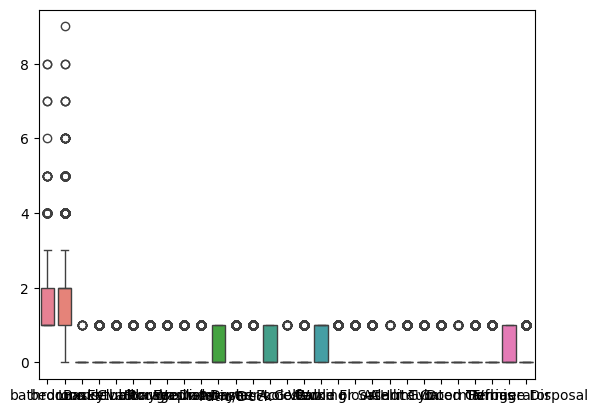

In [77]:
sns.boxplot(outliersdata)

### **Encoding**

In [59]:
encodingdata=phaseOne_data.copy()

In [60]:
for col in encodingdata.columns :
    if encodingdata[col].dtype == "category" :
        encodingdata[col]=encodingdata[col].cat.codes
    

In [61]:
encodingdata.head(10)

,index,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,latitude,...,AC,Alarm,Hot Tub,Gym,Gated,Doorman,TV,Tennis,Refrigerator,Garbage Disposal
0,0,2,2,1,1,1194,800,221,26,35.7585,...,0,0,0,1,0,0,0,0,0,0
1,1,1,1,1,1,1370,795,763,47,43.0724,...,0,0,0,0,0,0,0,0,1,1
2,2,1,1,1,1,1009,560,481,9,29.6533,...,0,0,0,0,0,0,0,1,1,0
3,3,1,1,1,1,695,600,982,28,41.2562,...,0,0,0,0,0,0,0,0,0,0
4,4,3,3,1,1,3695,1600,747,4,34.0372,...,0,0,0,0,0,0,0,0,0,0
5,5,2,3,1,1,1750,2300,77,18,30.4415,...,0,0,0,0,0,0,0,0,0,0
6,6,1,2,1,1,2470,1079,759,46,47.8616,...,0,0,0,1,0,0,0,0,0,0
7,7,2,3,1,1,1250,1177,1227,35,35.3537,...,0,0,0,0,0,0,0,0,0,0
8,8,1,1,1,1,1789,678,334,42,32.8212,...,0,0,0,0,0,0,0,0,0,0
9,9,1,2,1,1,1225,995,453,22,45.2764,...,0,0,0,0,0,0,0,0,1,0
